In [473]:
import matplotlib.image as img
import numpy as np
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
#from ml_metrics import rmse

import timeit


In [474]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

In [475]:
# read in the image
img = Image.open('einstein.jpg')
X_orig = np.array(img)

# save the original shape
orig_shape = X_orig.shape


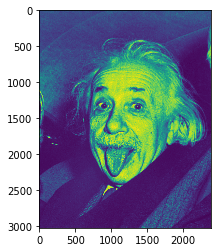

In [476]:
# From the original matrix
plt.imshow(X_orig, interpolation='nearest')
plt.show()

In [477]:
# function to create subsamples from the orig pixel matrix
# the subsamples are saved in a dictionary
def subsample_matrix(arr,subsamples):
    dict_subsamples = {}
    for sample in subsamples:
        sub_matrix = np.zeros((arr.shape[0],arr.shape[1]),dtype=np.int8)
        n = round(sample * arr.size)
        for k in range(n):
            i = np.random.randint(arr.shape[0])
            j = np.random.randint(arr.shape[1])
            sub_matrix[i,j] = arr[i,j]
        #print(sample,":",len(sub_matrix[np.nonzero(sub_matrix)]))
        dict_subsamples.update({sample:sub_matrix})
    return dict_subsamples
    

In [478]:
# for s= 0.1%, 1%, 5% and 10%
subsamples = [0.001,0.01,0.05,0.1]
#dict_subsamples.clear()
dict_subsamples = {}

# create subsamples from the original dense matrix
dict_subsamples = subsample_matrix(X_orig,subsamples)


In [480]:
#Training sets 
s_1 = dict_subsamples[0.001]
s_2 = dict_subsamples[0.01]
s_3 = dict_subsamples[0.05]
s_4 = dict_subsamples[0.1]

# Create test sets
X_test_1 = np.subtract(X_orig,s_1)
X_test_2 = np.subtract(X_orig,s_2)
X_test_3 = np.subtract(X_orig,s_3)
X_test_4 = np.subtract(X_orig,s_4)

In [481]:
# TRUE SVD
# Compute True SVD of the original Matrix

svd = TruncatedSVD(n_components=10,random_state=42,algorithm='randomized')
X_transformed = svd.fit_transform(X_orig)

# because singular_values_ contains Sigma as a vector
U = X_transformed / svd.singular_values_
Sigma = (np.diag(svd.singular_values_))
VT = svd.components_

# TruncatedSVD is an approximation of X
#  X ≈ X' = UΣV*
# X_approx = low-rank (10) approximation of X
#X_approx = np.matmul(np.matmul(U, Sigma), VT)

X_approx = U@Sigma@VT


In [482]:
svd.singular_values_

array([252314.18477583,  50867.4774053 ,  47303.12429797,  37081.11667692,
        32322.63047894,  23453.3467116 ,  22117.11956677,  16677.35702178,
        15245.04462523,  14258.4211768 ])

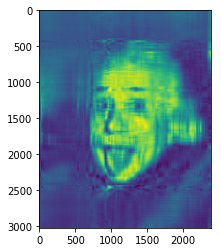

In [483]:
# reconsructed image using 10 components
plt.imshow(X_approx, interpolation='nearest')
plt.show()

In [484]:
# compute rmse between original and predicted matrix
def rmse(original, predicted):
    predicted = predicted[original.nonzero()].flatten()
    original = original[original.nonzero()].flatten()
    return np.sqrt(((predicted - original) ** 2).mean())


In [485]:
# performs truncatedSVD on each of the subsamples and reconstructs the image;
# outputs error and std
def compute_SVD(train,test,svd,orig_low_rank):
    
    X_transformed = svd.fit_transform(train)
    X_test_tr = svd.transform(test)
    U_ = X_test_tr/svd.singular_values_
    Sig_ = np.diag(svd.singular_values_)
    Vt = svd.components_
    
    # reconstruct predicted image   
    X_test_predicted = U_@Sig_@Vt
    
    #calculate mean bias and std. deviation WRT trueSVD (with 10 components) of the original matrix
    bias = rmse(orig_low_rank,X_test_predicted)
    print("Bias:",bias)
    sd = np.std(orig_low_rank - X_test_predicted)
    print("Std Deviation:",sd)
    
    #plot predicted image
    plt.imshow(X_test_predicted, interpolation='nearest')
    plt.show()
    
    # returns eigenvector from the svd of the training set
    return U_, Vt
    

In [498]:
# function to compute cosine similarity between the true_SVD and predicted_set for each sample
# cosine similarity is computed for the U and V vectors and then top K are chosen
def cos_distance(trueSVD_U, predicted_U,k=10):
    
    cos_sim = cosine_similarity(trueSVD_U, predicted_U)
    
    #flatten the ndarray
    sim_flat = cos_sim.ravel()
    #print("Similarity scores:",cos_sim)
       
    #sim_topK    
    sim_topK = -np.sort(-sim_flat,axis=None)[:k]
    print("Top:",k,"similarity scores:", sim_topK)
    
    avg_cos_sim = np.mean(cos_sim)
    print("Avg cosine similarity:",avg_cos_sim)
    
    #get indices
    #sort_idx = np.argsort(-cos_sim)
    #print("Top K :",sort_idx[:k])
    return avg_cos_sim, cos_sim
    
    
    

Bias: 99.74220971439723
Std Deviation: 66.8847149850258


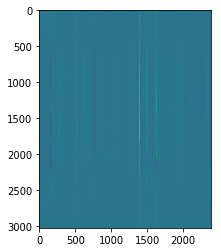

Bias: 58.97491001757743
Std Deviation: 56.42897095961765


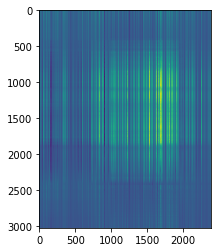

Bias: 39.3229874475054
Std Deviation: 39.06902889683758


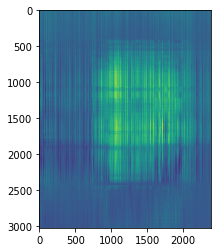

Bias: 33.765459452624036
Std Deviation: 33.557384165404464


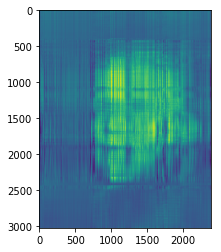

In [487]:
# Calculating bias, std deviation and plotting the predicted image for each subsample
# directly using the svd model from the original image
U_1, VT_1 = compute_SVD(s_1,X_test_1,svd,X_approx) # 0.1%
U_2, VT_2 = compute_SVD(s_2,X_test_2,svd,X_approx) # 1%
U_3, VT_3 = compute_SVD(s_3,X_test_3,svd,X_approx) # 5%
U_4, VT_4 = compute_SVD(s_4,X_test_4,svd,X_approx) # 10%

In [499]:
# calculating cosine distance using function (cosine_similarity) for each sub sample
# for vector U: choosing top K =10
# since the HW asks to compute TOP KXK matrix of cosine similarities, based on top K eigenvectors, taking a transpose of U
avg_U1, cos_U1 = cos_distance(U.T,U_1.T,10)
avg_U2, cos_U2 = cos_distance(U.T,U_2.T,10)
avg_U3, cos_U3 = cos_distance(U.T,U_3.T,10)
avg_U4, cos_U4 = cos_distance(U.T,U_4.T,10)


Top: 10 similarity scores: [0.65676195 0.58693933 0.54054255 0.49374075 0.48768503 0.29752802
 0.28476979 0.26769135 0.22818544 0.19371175]
Avg cosine similarity: -0.027903376240078086
Top: 10 similarity scores: [0.96542029 0.8468822  0.67788741 0.57456672 0.55648173 0.35712436
 0.29760593 0.27158963 0.26746838 0.25739845]
Avg cosine similarity: -0.024201937678505838
Top: 10 similarity scores: [0.98070229 0.60596354 0.55307147 0.47089259 0.44925268 0.44228656
 0.40632259 0.34034828 0.3315923  0.29911099]
Avg cosine similarity: -0.054786697575493475
Top: 10 similarity scores: [0.98575026 0.72442086 0.70492778 0.61803323 0.55702528 0.52181089
 0.5016027  0.44907554 0.41888252 0.41871325]
Avg cosine similarity: 0.007461841606315658


In [502]:
avg_V1, cos_V1 = cos_distance(VT,VT_1,10)
avg_V2, cos_V2 = cos_distance(VT,VT_2,10)
avg_V3, cos_V3 = cos_distance(VT,VT_3,10)
avg_V4, cos_V4 = cos_distance(VT,VT_4,10)


Top: 10 similarity scores: [0.06382425 0.05622354 0.04516899 0.04223735 0.03995739 0.03854614
 0.03830836 0.03566808 0.03489705 0.03227447]
Avg cosine similarity: 0.0027391517663655452
Top: 10 similarity scores: [0.40426143 0.37189869 0.36288041 0.13928438 0.11276067 0.09584476
 0.09278456 0.08902764 0.08802601 0.06318727]
Avg cosine similarity: -0.009430852488760423
Top: 10 similarity scores: [0.56740844 0.4436355  0.35863885 0.35414739 0.32835939 0.30426761
 0.22680194 0.20141893 0.18275647 0.18053152]
Avg cosine similarity: -0.009213563500447662
Top: 10 similarity scores: [0.61062755 0.42992046 0.38572912 0.38332619 0.37167025 0.34275705
 0.33791748 0.33627669 0.26615215 0.26306279]
Avg cosine similarity: 0.013329356527534553


In [524]:
# use kfold
# for each subsample, split into 5 or 10;
# using the low_rank matrix (for comparison) obtained using SVD (10 components)

def cv_kfold(X_subsample, X_orig,n_kf,svd_cv):
    
    prediction_scores = []
    kfolds = KFold(n_splits=n_kf,shuffle=True)
    #kfolds.get_n_splits(s_1)
    
    for train_idx, test_idx in kfolds.split(X_subsample):
        train_data,test_data = X_subsample[train_idx], X_subsample[test_idx]
        X_orig_train, X_orig_test = X_orig[train_idx], X_orig[test_idx]
        X_d = svd_cv.fit_transform(train_data)
        X_d_test = svd_cv.transform(test_data)
    
        U_k = X_d_test / svd_cv.singular_values_
        Sigma_k = np.diag(svd_cv.singular_values_)
        VT_k = svd_cv.components_
        X_predicted = U_k@Sigma_k@VT_k
        prediction_scores.append(rmse(X_orig_test,X_predicted)) 
    
    best_score = min(prediction_scores)
    std = np.std(prediction_scores)
    avg_score = np.mean(prediction_scores)
    
    return std, avg_score, svd_cv   


In [526]:
# initializing a new svd object to be trained using cross-validation; using 10 components
svd_cv = TruncatedSVD(n_components=10,random_state=42,algorithm='randomized')

In [529]:
#performing cross validation on each subsample using 10 folds
std_1,as_1,svd_m1 = cv_kfold(s_1,X_approx,10,svd_cv)
std_2,as_2,svd_m2 = cv_kfold(s_2,X_approx,10,svd_cv)
std_3,as_3,svd_m3 = cv_kfold(s_3,X_approx,10,svd_cv)
std_4,as_4,svd_m4 = cv_kfold(s_4,X_approx,10,svd_cv)

In [530]:
print(std_1,as_1)
print(std_2,as_2)
print(std_3,as_3)
print(std_4,as_4)

1.8254636675950793 100.16780642792716
2.1666187741257708 100.18263295874928
2.124203156893272 100.41266705359543
1.992216814300339 100.79045480809603


In [533]:
# using the model trained by cross validation to reconstruct the image
def cv_result(svd_model,train,test):
    
    # If the model(svd_model) passed to this funtion is not fit on training data, it still performs well
    X_cv = svd_model.fit_transform(train)
    X_test_cv = svd_model.transform(test)

    U_cv = X_test_cv / svd_model.singular_values_
    Sigma_cv = (np.diag(svd_model.singular_values_))
    VT_cv = svd_model.components_
    
    X_approx_cv = U_cv@Sigma_cv@VT_cv
    print("Reconstruction from CV!\n")
    plt.imshow(X_approx_cv, interpolation='nearest')
    plt.show()
    
    return U_cv,VT_cv

Reconstruction from CV!



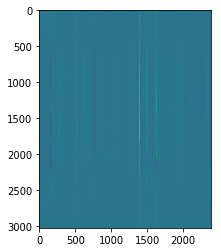

Reconstruction from CV!



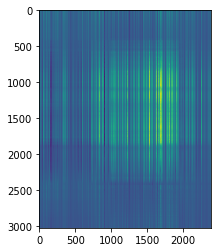

Reconstruction from CV!



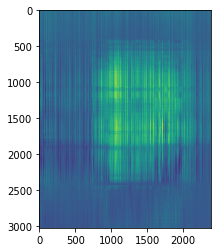

Reconstruction from CV!



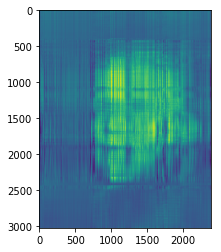

In [534]:
# Using the svd models trained using CV to reconstruct the image, for each subsample
U_cv1,VT_cv1 = cv_result(svd_m1,s_1,X_test_1)
U_cv2,VT_cv2 = cv_result(svd_m2,s_2,X_test_2)
U_cv3,VT_cv3 = cv_result(svd_m3,s_3,X_test_3)
U_cv4,VT_cv4 = cv_result(svd_m4,s_4,X_test_4)

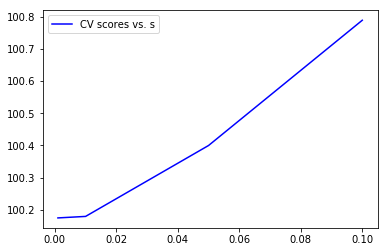

In [510]:
# Plot cv prediction error as a function of sparsity
cv_scores = [as_1,as_2,as_3,as_4]
subsamples = [0.001,0.01,0.05,0.1]
x = subsamples
y = cv_scores
plt.plot(x,y, color="b")
plt.legend(['CV scores vs. s'])
plt.show()

In [535]:
# Cosine similiarites for the V matrix from CV output

avg_cv_V1, cos_cv_V1 = cos_distance(VT,VT_cv1,10)
avg_cv_V2, cos_cv_V2 = cos_distance(VT,VT_cv2,10)
avg_cv_V3, cos_cv_V3 = cos_distance(VT,VT_cv3,10)
avg_cv_V4, cos_cv_V4 = cos_distance(VT,VT_cv4,10)

Top: 10 similarity scores: [0.06382425 0.05622354 0.04516899 0.04223735 0.03995739 0.03854614
 0.03830836 0.03566808 0.03489705 0.03227447]
Avg cosine similarity: 0.0027391517663655452
Top: 10 similarity scores: [0.40426143 0.37189869 0.36288041 0.13928438 0.11276067 0.09584476
 0.09278456 0.08902764 0.08802601 0.06318727]
Avg cosine similarity: -0.009430852488760423
Top: 10 similarity scores: [0.56740844 0.4436355  0.35863885 0.35414739 0.32835939 0.30426761
 0.22680194 0.20141893 0.18275647 0.18053152]
Avg cosine similarity: -0.009213563500447662
Top: 10 similarity scores: [0.61062755 0.42992046 0.38572912 0.38332619 0.37167025 0.34275705
 0.33791748 0.33627669 0.26615215 0.26306279]
Avg cosine similarity: 0.013329356527534553


In [536]:
# Cosine similiarites for the U matrix from CV output
avg_cv_U1, cos_cv_U1 = cos_distance(U.T,U_cv1.T,10)
avg_cv_U2, cos_cv_U2 = cos_distance(U.T,U_cv2.T,10)
avg_cv_U3, cos_cv_U3 = cos_distance(U.T,U_cv3.T,10)
avg_cv_U4, cos_cv_U4 = cos_distance(U.T,U_cv4.T,10)

Top: 10 similarity scores: [0.65676195 0.58693933 0.54054255 0.49374075 0.48768503 0.29752802
 0.28476979 0.26769135 0.22818544 0.19371175]
Avg cosine similarity: -0.027903376240078086
Top: 10 similarity scores: [0.96542029 0.8468822  0.67788741 0.57456672 0.55648173 0.35712436
 0.29760593 0.27158963 0.26746838 0.25739845]
Avg cosine similarity: -0.024201937678505838
Top: 10 similarity scores: [0.98070229 0.60596354 0.55307147 0.47089259 0.44925268 0.44228656
 0.40632259 0.34034828 0.3315923  0.29911099]
Avg cosine similarity: -0.054786697575493475
Top: 10 similarity scores: [0.98575026 0.72442086 0.70492778 0.61803323 0.55702528 0.52181089
 0.5016027  0.44907554 0.41888252 0.41871325]
Avg cosine similarity: 0.007461841606315658


In [511]:
# Normalize a matrix -- for svd_solve
def normalize_matrix(X_):
    mean_ = []
    std_ = []
    long_axis = max(X_.shape)
    X_normalized = np.zeros((X_.shape[0],X_.shape[1]))
    for i in range(long_axis):
        mean_.append(np.mean(X_[i,:]))
        std_.append(np.std(X_[i,:]))
            
    for i in range(long_axis):
        X_normalized[i,:] = (X_[i,:] - mean_[i])/std_[i]
            
    return X_normalized

# compute the predicted matrix using U and V vectors
def predicted_mat(U,V):
    return np.dot(U,V.T)


In [512]:
## Gradient Descent
# takes as input, the X_train sub samples of the original matrix;
# User defined value for K, lrate and lam
#lrate = 0.001 # from S.Funk's blog

## X_train and X_test are normalized
def svd_solve(X_train,X_test, K, lrate, lam, n_epochs):
    dict_predicted_mat = {}
       
    #get non_zero indices of the input matrix
    row,col = X_train.nonzero()
    
    #initialize vectors u and v
    u = np.random.normal(0, .1, (X_train.shape[0], K))
    v = np.random.normal(0, .1, (X_train.shape[1], K))
    
    # to save error scores
    train_error = []
    test_error = []
         
    for epoch in range(n_epochs):
        
        for i,j in zip(row,col):
            #update error matrix
            Err = X_train[i,j] - predicted_mat(u[i,:],v[j,:])
            # update u_i,v_j                     
            u[i,:] += lrate * (Err * v[j,:] - lam * u[i,:])
            v[j,:] += lrate * (Err * u[i,:] - lam * v[j,:])       
            
        train_rmse = rmse(predicted_mat(u,v), X_train)
        #dict_predicted_mat.update({train_rmse:[predicted_mat(u,v),u,v]})
        test_rmse = rmse(predicted_mat(u,v), X_test)
        dict_predicted_mat.update({test_rmse:[predicted_mat(u,v),u,v]})
        train_error.append(train_rmse)
        test_error.append(test_rmse)
       
    # Check performance by plotting train and test errors
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    ax1.plot(train_error, color="g", label='Training RMSE')
    ax2.plot(test_error, color="r", label='Test RMSE')
    
    ax1.set(title='Training error',xlabel='Num of Epochs',ylabel='RMSE')
    ax2.set(title='Test error',xlabel='Num of Epochs',ylabel='RMSE')
        
    ax1.legend()
    ax2.legend()
    
    return dict_predicted_mat  

In [513]:
# normalize the ORIGINAL matrix
X_normalized = normalize_matrix(X_orig)


In [515]:
# create subsamples from the normalized matrix
dict_normalized_ss = {}
dict_normalized_ss = subsample_matrix(X_normalized,subsamples)

In [516]:
#Training sets 
X_train_n1 = dict_normalized_ss[0.001]
X_train_n2 = dict_normalized_ss[0.01]
X_train_n3 = dict_normalized_ss[0.05]
X_train_n4 = dict_normalized_ss[0.1]

# Create test sets
X_test_n1 = np.subtract(X_normalized,X_train_n1)
X_test_n2 = np.subtract(X_normalized,X_train_n1)
X_test_n3 = np.subtract(X_normalized,X_train_n1)
X_test_n4 = np.subtract(X_normalized,X_train_n1)

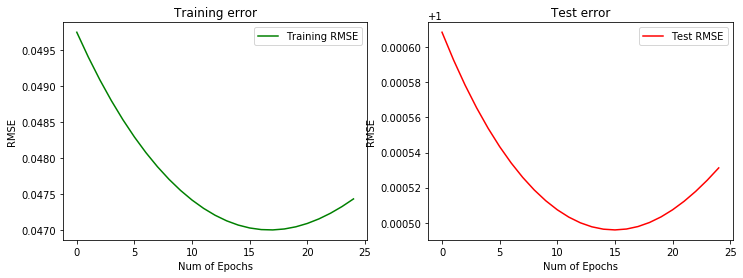

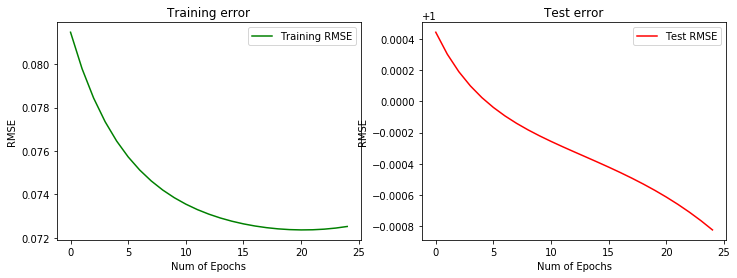

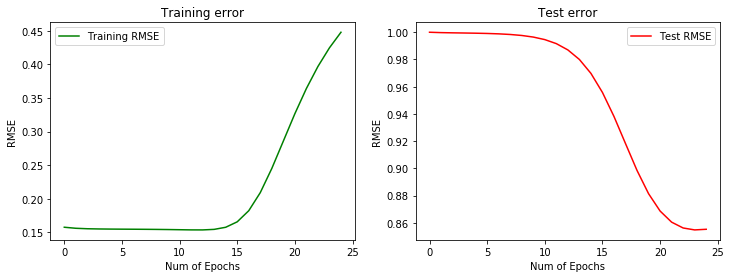

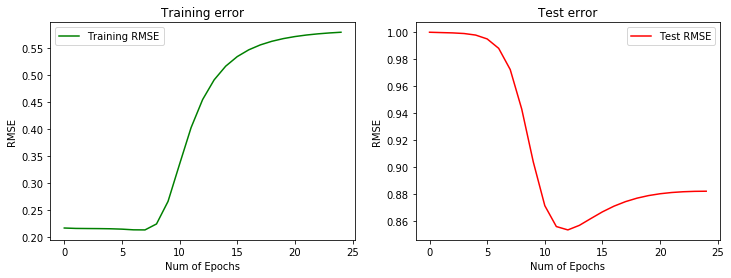

In [521]:
## using lrate = 0.01 (with 0.001, I get worse images)
# K_max = 20

dict_output_mat_1 = svd_solve(X_train_n1,X_test_n1,20,0.01,0.5,25)
dict_output_mat_2 = svd_solve(X_train_n2,X_test_n2,20,0.01,0.5,25)
dict_output_mat_3 = svd_solve(X_train_n3,X_test_n3,20,0.01,0.5,25)
dict_output_mat_4 = svd_solve(X_train_n4,X_test_n4,20,0.01,0.5,25)


In [522]:
# breakdown the output from svd_solve
# it is a dictionary with items as a list and containing predicted matrix,u,v
def output_svd_solve(dict_):
    from collections import OrderedDict
    sort_dict = OrderedDict(sorted(dict_.items(), key=lambda k: k[0]))
    best_score = next(iter(sort_dict))
    # this is a list containing the predicted matrix, matrices U and V, in that order
    best_output = dict_[best_score]
    pred_matx = best_output[0]
    U = best_output[1]
    V = best_output[2]
    plt.imshow(pred_matx, interpolation='nearest')
    plt.show()
    
    return pred_matx, U, V



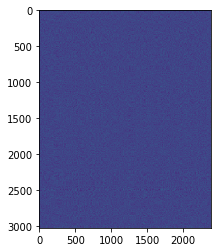

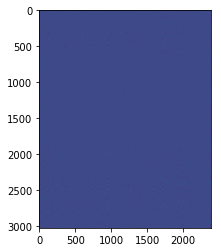

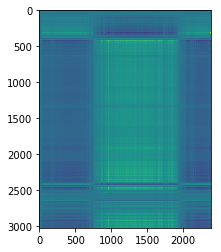

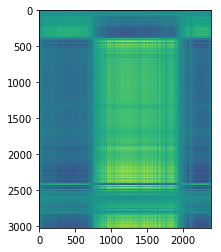

In [523]:
# get best predicted matrix and plot
ss_pred_mat1,ss_u1,ss_v1 = output_svd_solve(dict_output_mat_1)
ss_pred_mat2,ss_u2,ss_v2 = output_svd_solve(dict_output_mat_2)
ss_pred_mat3,ss_u3,ss_v3 = output_svd_solve(dict_output_mat_3)
ss_pred_mat4,ss_u4,ss_v4 = output_svd_solve(dict_output_mat_4)

In [537]:
# compute cosine distances for U and V vectors
avg_ss_U1, cos_ss_U1 = cos_distance(U.T,ss_u1.T,10)
avg_ss_U2, cos_ss_U2 = cos_distance(U.T,ss_u2.T,10)
avg_ss_U3, cos_ss_U3 = cos_distance(U.T,ss_u3.T,10)
avg_ss_U4, cos_ss_U4 = cos_distance(U.T,ss_u4.T,10)

avg_ss_V1, cos_ss_V1 = cos_distance(VT,ss_v1.T,10)
avg_ss_V2, cos_ss_V2 = cos_distance(VT,ss_v2.T,10)
avg_ss_V3, cos_ss_V3 = cos_distance(VT,ss_v3.T,10)
avg_ss_V4, cos_ss_V4 = cos_distance(VT,ss_v4.T,10)


Top: 10 similarity scores: [0.05198819 0.04020212 0.03870147 0.03843067 0.03617102 0.03362672
 0.03188799 0.03186107 0.03019649 0.02958475]
Avg cosine similarity: -0.0007007164680550812
Top: 10 similarity scores: [0.11107351 0.09000166 0.06539227 0.06473566 0.05989745 0.04905178
 0.04863674 0.04658385 0.0463413  0.04558234]
Avg cosine similarity: -0.001366376881150152
Top: 10 similarity scores: [0.77191658 0.74178444 0.73314874 0.72887362 0.40806436 0.34671252
 0.28944782 0.2735824  0.25506644 0.24594183]
Avg cosine similarity: -0.01686213603716147
Top: 10 similarity scores: [0.69454312 0.69152614 0.68402848 0.66199102 0.64646052 0.61723624
 0.60639735 0.54666248 0.47034955 0.38672985]
Avg cosine similarity: -0.009299266970484244
Top: 10 similarity scores: [0.057186   0.05216134 0.04872635 0.04532731 0.04307221 0.03855408
 0.03802111 0.03717502 0.03639572 0.03595514]
Avg cosine similarity: 0.0009817410904478215
Top: 10 similarity scores: [0.14512449 0.12086068 0.09186283 0.08535198 0.0

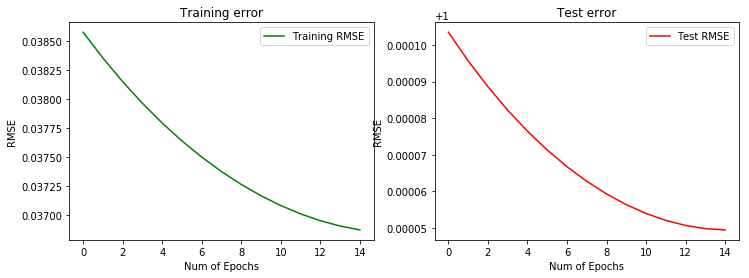

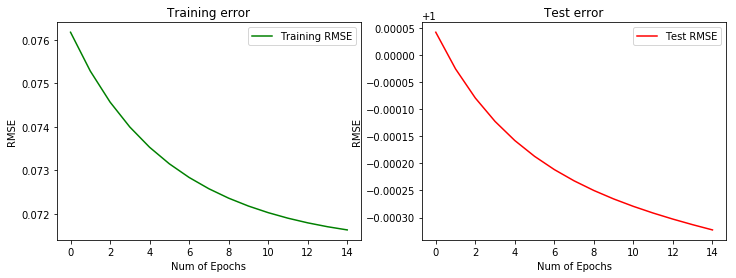

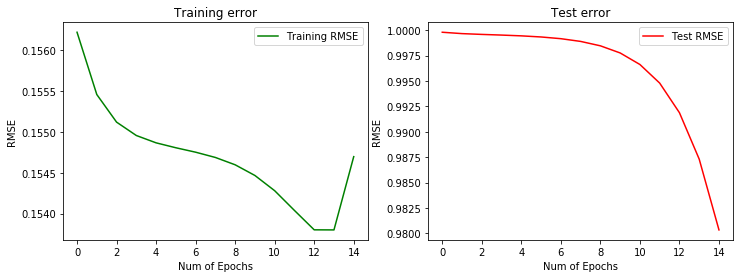

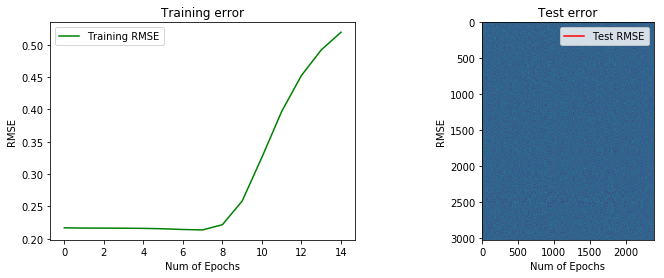

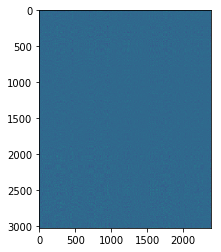

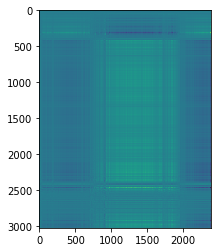

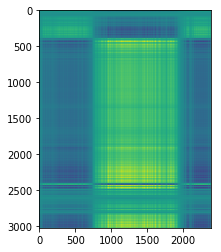

In [541]:
## using lrate = 0.01 (with 0.001, I get worse images)
# K_max = 10

dict_output_mat_1 = svd_solve(X_train_n1,X_test_n1,10,0.01,0.5,15)
dict_output_mat_2 = svd_solve(X_train_n2,X_test_n2,10,0.01,0.5,15)
dict_output_mat_3 = svd_solve(X_train_n3,X_test_n3,10,0.01,0.5,15)
dict_output_mat_4 = svd_solve(X_train_n4,X_test_n4,10,0.01,0.5,15)

# get best predicted matrix and plot: K_max = 10
ss_pred_mat1,ss_u1,ss_v1 = output_svd_solve(dict_output_mat_1)
ss_pred_mat2,ss_u2,ss_v2 = output_svd_solve(dict_output_mat_2)
ss_pred_mat3,ss_u3,ss_v3 = output_svd_solve(dict_output_mat_3)
ss_pred_mat4,ss_u4,ss_v4 = output_svd_solve(dict_output_mat_4)


In [542]:
avg_ss_U1, cos_ss_U1 = cos_distance(U.T,ss_u1.T,10)
avg_ss_U2, cos_ss_U2 = cos_distance(U.T,ss_u2.T,10)
avg_ss_U3, cos_ss_U3 = cos_distance(U.T,ss_u3.T,10)
avg_ss_U4, cos_ss_U4 = cos_distance(U.T,ss_u4.T,10)

avg_ss_V1, cos_ss_V1 = cos_distance(VT,ss_v1.T,10)
avg_ss_V2, cos_ss_V2 = cos_distance(VT,ss_v2.T,10)
avg_ss_V3, cos_ss_V3 = cos_distance(VT,ss_v3.T,10)
avg_ss_V4, cos_ss_V4 = cos_distance(VT,ss_v4.T,10)

Top: 10 similarity scores: [0.034655   0.03195479 0.02853922 0.02817101 0.02644426 0.02633951
 0.02543494 0.02489977 0.02183018 0.02020578]
Avg cosine similarity: -0.0016344870631497873
Top: 10 similarity scores: [0.05760565 0.04971125 0.04145366 0.03960428 0.03954841 0.03396362
 0.03384085 0.03251264 0.02948654 0.02931034]
Avg cosine similarity: -6.879680034611102e-05
Top: 10 similarity scores: [0.73501592 0.50860987 0.26505299 0.22987707 0.18723238 0.1519641
 0.13827414 0.13218326 0.13053068 0.11669639]
Avg cosine similarity: -0.01048150674870989
Top: 10 similarity scores: [0.74613784 0.73461557 0.56898422 0.2710373  0.23591023 0.19980484
 0.18615745 0.17919216 0.16160941 0.1461224 ]
Avg cosine similarity: -0.02396705780820234
Top: 10 similarity scores: [0.05738406 0.04848385 0.035706   0.03500904 0.03397677 0.03350422
 0.03247908 0.03192001 0.03146897 0.02845226]
Avg cosine similarity: 0.002254766968918849
Top: 10 similarity scores: [0.0588328  0.05606451 0.04683791 0.04600628 0.038

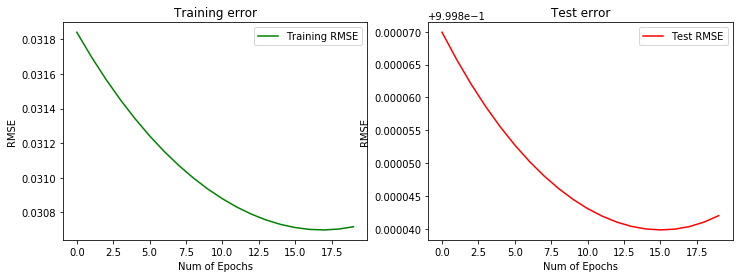

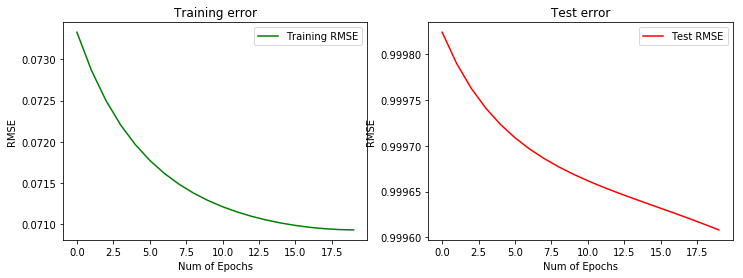

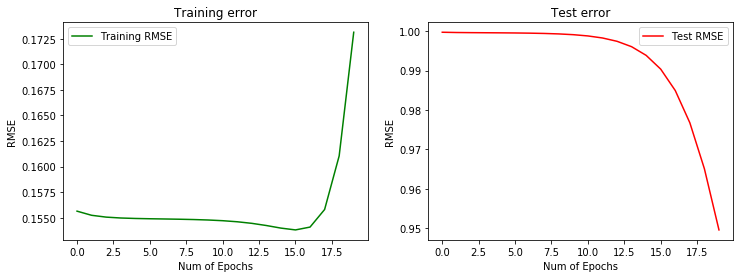

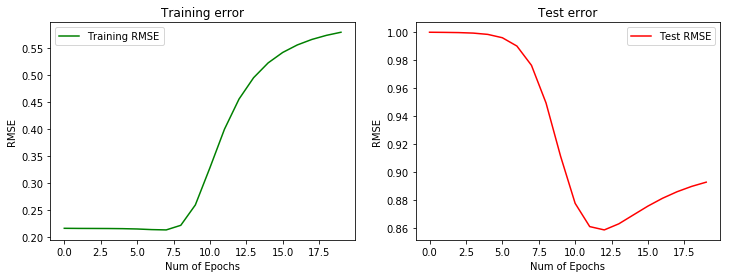

In [543]:
## using lrate = 0.01 (with 0.001, I get worse images)
# K_max = 5

dict_output_mat_1 = svd_solve(X_train_n1,X_test_n1,5,0.01,0.5,20)
dict_output_mat_2 = svd_solve(X_train_n2,X_test_n2,5,0.01,0.5,20)
dict_output_mat_3 = svd_solve(X_train_n3,X_test_n3,5,0.01,0.5,20)
dict_output_mat_4 = svd_solve(X_train_n4,X_test_n4,5,0.01,0.5,20)

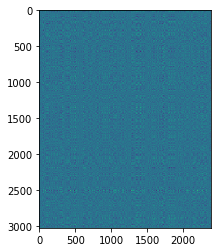

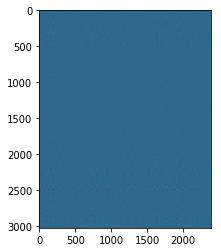

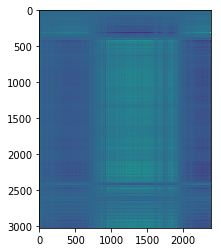

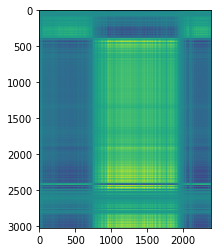

In [544]:
# get best predicted matrix and plot: K_max = 5
ss_pred_mat1,ss_u1,ss_v1 = output_svd_solve(dict_output_mat_1)
ss_pred_mat2,ss_u2,ss_v2 = output_svd_solve(dict_output_mat_2)
ss_pred_mat3,ss_u3,ss_v3 = output_svd_solve(dict_output_mat_3)
ss_pred_mat4,ss_u4,ss_v4 = output_svd_solve(dict_output_mat_4)

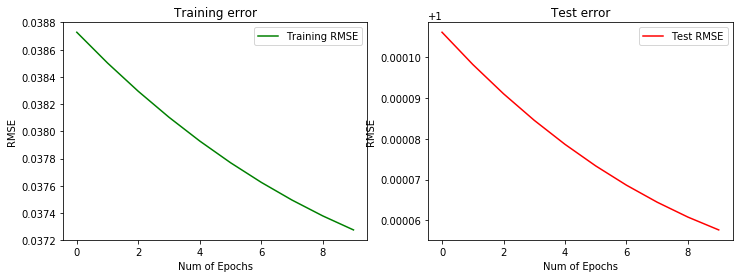

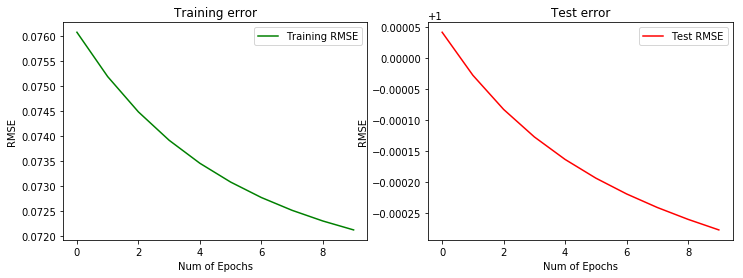

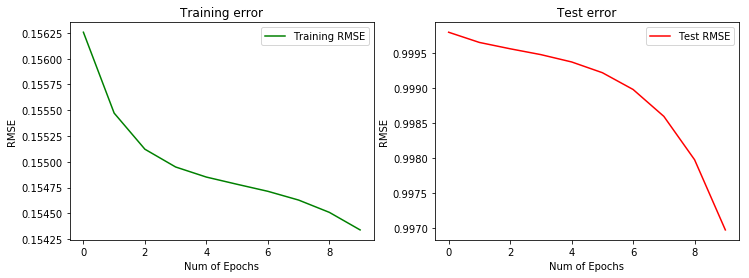

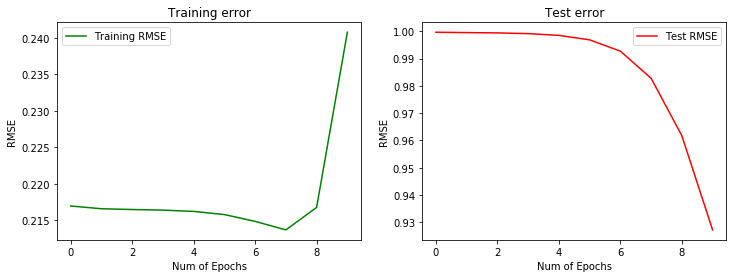

In [545]:
## using lrate = 0.01 (with 0.001, I get worse images)
# K_max = 10

dict_output_mat_1 = svd_solve(X_train_n1,X_test_n1,10,0.01,0.5,10)
dict_output_mat_2 = svd_solve(X_train_n2,X_test_n2,10,0.01,0.5,10)
dict_output_mat_3 = svd_solve(X_train_n3,X_test_n3,10,0.01,0.5,10)
dict_output_mat_4 = svd_solve(X_train_n4,X_test_n4,10,0.01,0.5,10)

Conculsion: 
    Just going by the reconstructed images, Kfold CV seems to do well; 
    I need to tune the parameters further in the svd_solve (SGD) method to obtain a better accuracy. Techinically, this
    algorithm is supposed to perform better.
    Also, I see that the average cosine distance (similarity scores) is under 10% for K_max=10 and 20.

Cross Validation is useful when the dataset is small/limited and still provides a fairly close estimate of the accuracy. 
Gradient Descent makes sense in many scenarious as we do not always encounter a convex function and finding global minima
is not straightforward. GD is used to minimize the cost function and increase accuracy while adjusting weights/learning rates.